# Table of Contents
 <p><div class="lev1"><a href="#Download-and-visualize-your-own-tweet-text"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and visualize your own tweet text</a></div><div class="lev2"><a href="#Get-access-to-Twitter-API"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get access to Twitter API</a></div><div class="lev2"><a href="#Steam-tweets"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Steam tweets</a></div><div class="lev2"><a href="#Parse-tweets"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Parse tweets</a></div><div class="lev2"><a href="#Clean-text"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Clean text</a></div><div class="lev2"><a href="#Create-a-word-cloud"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Create a word cloud</a></div><div class="lev1"><a href="#Text-analysis-on-entrepreneurship-tweets"><span class="toc-item-num">2&nbsp;&nbsp;</span>Text analysis on entrepreneurship tweets</a></div><div class="lev2"><a href="#Read-and-clean-text"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read and clean text</a></div><div class="lev2"><a href="#Look-at-distribution-of-number-of-re-tweets"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Look at distribution of number of re-tweets</a></div><div class="lev2"><a href="#Create-a-word-cloud"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Create a word cloud</a></div><div class="lev2"><a href="#Statistics-on-number-of-re-tweets"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Statistics on number of re-tweets</a></div><div class="lev2"><a href="#Denote-instances-where-number-of-re-tweets-is-more-than-1-and-zero"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Denote instances where number of re-tweets is more than 1 and zero</a></div><div class="lev2"><a href="#Create-word-clouds-for-cases-with-2+-re-tweets-and-with-no-tweets"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Create word clouds for cases with 2+ re-tweets and with no tweets</a></div><div class="lev2"><a href="#Get-terms-frequencies"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Get terms frequencies</a></div><div class="lev2"><a href="#Plot-terms-frequencies"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Plot terms frequencies</a></div><div class="lev2"><a href="#Create-Bigrams"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Create Bigrams</a></div>

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import pandas as pd
pd.options.mode.chained_assignment = None
import json
import numpy as np
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer 
from ipywidgets import *
#import nltk
#nltk.download()

In [2]:
%%R
library(rjson)
library(RCurl) 
library(ROAuth)
library(streamR)

/home/andrey/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: bitops

  warnings.warn(x, RRuntimeWarning)


In [3]:
tokenizer=WordPunctTokenizer()
lemmatizer=WordNetLemmatizer()
stemmer=PorterStemmer()
stopWords=stopwords.words('english')
customList=['amp','rt','via','quot']
exclude=stopWords+customList

**Great source to test regular expressions** https://regex101.com/#python 

In [19]:
def cleaning(text,lem_mode=True):

    '''Function
    --------
    Return a tweet after removing urls, RTs, and characters, which are not letters.
    Also lemmitizes or stems words in tweet

    Parameters
    ----------
    text : str
        Orifinal tweet
    mode : str
        if 'lem' then function  lemmatizes words in a tweet, else stems 

    Returns
    -------
    clean tweet : str'''
    
    text = re.sub(r'\s*RT\s\S*\s', '', text)  # delete any number of RT....
    text = re.sub(r'http\S*', '', text)  # remove url
    words = tokenizer.tokenize(text.lower())
    cleanWords=[word for word in words if word not in exclude]
    lemWords=[]
    stemWords=[]
    for word in cleanWords:    
        letters=''.join([letter for letter in word if letter.isalpha()])# keeps only letters
        if lem_mode:
            lemWords.append(lemmatizer.lemmatize(letters)) # for better lemmatizing Part Of Speech tags are requered
            continue
        stemWords.append(stemmer.stem(letters))
    if lem_mode:        
        return  ' '.join(lemWords)
    else: 
        return ' '.join(stemWords)   

In [ ]:
def termFreq(data,max_features):
    
    '''Function
    --------
    Return a data frame with number of words occurances in corpus
    Parameters
    ----------
    data : Series
        series with tweets
        
    max_features : int
        number of most frequent words  

    Returns
    -------
    table with frequencies : data frame'''    
    
    vectorizer=CountVectorizer(max_features=max_features)
    matrix=vectorizer.fit_transform(data).todense()
    matrixSum=np.sum(matrix, axis=0)
    return pd.DataFrame(matrixSum.transpose(),index = vectorizer.get_feature_names())    

# Download and visualize your own tweet text

## Get access to Twitter API

R provides very nice tools to stream tweets. Of course, there are ways to do it also in Python, but they are significantly more verbose. And there is no reason not to use the best of both words. 

In [ ]:
%%R
requestURL <- "https://api.twitter.com/oauth/request_token"
accessURL <- "https://api.twitter.com/oauth/access_token"
authURL <- "https://api.twitter.com/oauth/authorize"
consumerKey <- "XXX"
consumerSecret <- "XXX"

my_oauth <- OAuthFactory$new(consumerKey = consumerKey, consumerSecret = consumerSecret,requestURL = requestURL,
                             accessURL = accessURL, authURL = authURL)

my_oauth$handshake(cainfo = system.file("CurlSSL", "cacert.pem", package = "RCurl"))
save(my_oauth, file = "my_oauth.Rdata")

## Steam tweets

In [7]:
%%R
load("my_oauth.Rdata")
keyWord='apple'
filterStream(file.name = "tweets.json", # Save tweets in a json file
             track = keyWord, #
             language = "en",
             timeout = 60, # Keep connection alive for 60 seconds
             oauth = my_oauth) # Use my_oauth file as the OAuth credentials

/home/andrey/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Capturing tweets...

  warnings.warn(x, RRuntimeWarning)
/home/andrey/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Connection to Twitter stream was closed after 60 seconds with up to 266 tweets downloaded.

  warnings.warn(x, RRuntimeWarning)


## Parse tweets

We can retrieve parts of tweet that we are interested in from json string. In order to do so, we need to know the structure of a json file.  
* You can find an example of a tweet in json here:   https://github.com/AndreyKarasev/Data_Science_Class/blob/master/tweetStucure.json
* And here you can find detailed description of each field:  https://dev.twitter.com/overview/api

In [21]:
tweetList=[]
with open("tweets.json") as in_file:
    for line in in_file:
        tweet = json.loads(line)
        # Pull out various data from the tweets
        row = (
            tweet['id'],                      # tweet_id
            tweet['created_at'],              # tweet_time
            tweet['lang'],                    # tweet_language
            tweet['text'],                    # tweet_text
            tweet['retweeted'],               # retweeted
            tweet['source'],                  # tweet_source
            tweet['retweet_count'],           # retweets_number     
            tweet['user']['screen_name'],     # tweet_author
            tweet['user']['id_str'],          # tweet_authod_id  
            tweet['user']['followers_count'], # followers_number
            tweet['user']['listed_count'],    # lists_number
            tweet['user']['friends_count'],   # friends_number
            tweet['user']['favourites_count'],# favourites_number
            tweet['coordinates']              # longitude_latitude
        )
        values = [value for value in row]
        tweetList.append(values)
colNames='tweet_id,tweet_time,tweet_language,tweet_text,retweeted,tweet_source,\
retweets_number,tweet_author,tweet_authod_id,followers_number,lists_number,\
friends_number,favourites_number,longitude_latitude'.split(',')

tweetsDf=pd.DataFrame(tweetList,columns=colNames)
tweetsDf['longitude']=tweetsDf.longitude_latitude.apply(lambda x: x['coordinates'][0] if x else np.nan)
tweetsDf['latitude']=tweetsDf.longitude_latitude.apply(lambda x: x['coordinates'][1] if x else np.nan)

In [22]:
tweetsDf.head(2).T

,0,1
tweet_id,739836561051750400,739836560594636804
tweet_time,Mon Jun 06 15:09:16 +0000 2016,Mon Jun 06 15:09:16 +0000 2016
tweet_language,en,en
tweet_text,unbelievable prices on apple equipment @arifar...,Apple A1296 MB829LL Bluetooth Wireless Optical...
retweeted,False,False
tweet_source,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","<a href=""http://ifttt.com"" rel=""nofollow"">IFTT..."
retweets_number,0,0
tweet_author,xSoarix,zamiti_eud0
tweet_authod_id,6204892,3060846388
followers_number,56,127


## Clean text

In [24]:
tweetsDf['textCleanLem']=tweetsDf.tweet_text.apply(cleaning)# cleaning fuction has lem_mode=True by default
tweetsDf['textCleanStem']=tweetsDf.tweet_text.apply(lambda x: cleaning(x, lem_mode=False))
tweetsDf[['tweet_text','textCleanLem','textCleanStem']].head()

,tweet_text,textCleanLem,textCleanStem
0,unbelievable prices on apple equipment @arifar...,unbelievable price apple equipment arifarfu,unbeliev price appl equip arifarfu
1,Apple A1296 MB829LL Bluetooth Wireless Optical...,apple a mbll bluetooth wireless optical multi ...,appl a mbll bluetooth wireless optic multi to...
2,Apple iPhone 6 Plus Verizon 64GB Gold Model A1...,apple iphone plus verizon gb gold model a,appl iphon plu verizon gb gold model a
3,@ starbucks: better give me my passion tea wit...,starbucks better give passion tea apple juic...,starbuck better give passion tea appl juic time
4,https://t.co/LeMTHaSGB5 Apple iPhone 4s - 16GB...,apple iphone s gb white verizon smartphone...,appl iphon s gb white verizon smartphon ic...


## Create a word cloud

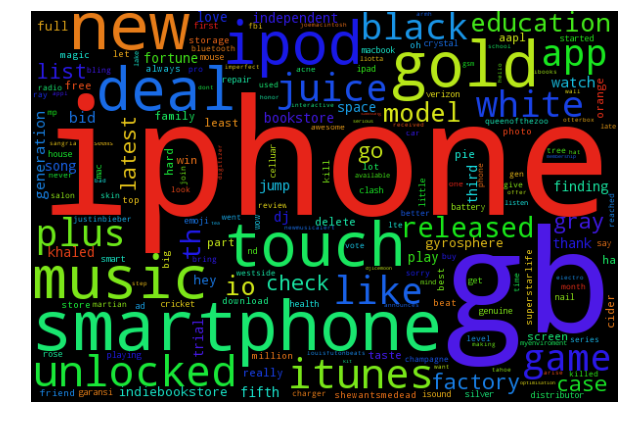

In [25]:
%Rpull keyWord
corpus=' '.join(tweetsDf.textCleanLem.tolist())
@interact(scaling=[0,1.0])
def cloud(scaling):
    wordcloud = WordCloud(background_color='black',height=400,width=600,
                          stopwords=(keyWord),relative_scaling=scaling).generate(corpus)
    plt.figure(figsize=(18,7))
    plt.axis("off") 
    plt.imshow(wordcloud)

# Text analysis on entrepreneurship tweets

## Read and clean text

In [4]:
df=pd.read_csv('twitter_train.csv', encoding='latin1')
df['textClean']=df.Text.apply(lambda x: cleaning(x, mode='stem'))
df.head(2)

,ID_str,Text,Created,Status_Source,Screen_Name,Latitude,Longitude,Followers_Count,RT_Count_in_TimeWindow,textClean
0,6.293928e+17,@ColorMeRed @krmccall The amount of business r...,Thu Aug 06 20:45:02 +0000 2015,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",KLSouth,NaN,NaN,34271,0,colorm krmccall amount busi regul cronyism ...
1,6.295560e+17,Mobilink Partners with LUMS to Enhance Entrepr...,Fri Aug 07 07:33:45 +0000 2015,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",mohsinrehman,NaN,NaN,160,0,mobilink partner lum enhanc entrepreneuri eco ...


## Look at distribution of number of re-tweets

(0.0, 10)

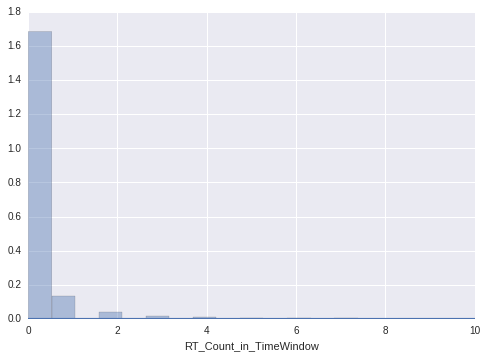

In [5]:
sns.distplot(df.RT_Count_in_TimeWindow,bins=2000)
plt.xlim([0.0, 10]) 

## Create a word cloud

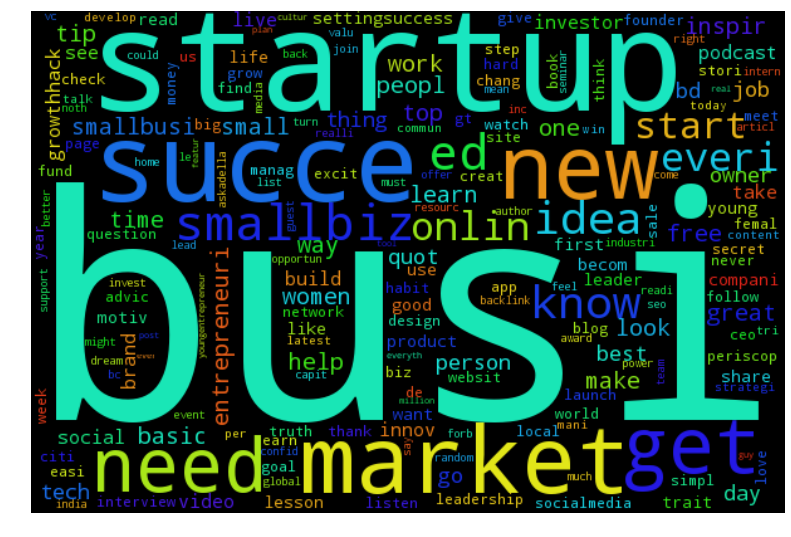

In [6]:
corpus=' '.join(df.textClean.tolist())
wordcloud = WordCloud(background_color='black',height=400,width=600,
                      stopwords=(['entrepreneur','entrepreneurship']),relative_scaling=0.5).generate(corpus)
plt.figure(figsize=(18,9))
plt.axis("off") 
plt.imshow(wordcloud)

## Statistics on number of re-tweets

In [7]:
df.RT_Count_in_TimeWindow.describe()

count    35270.000000
mean         0.582336
std         16.768241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1054.000000
Name: RT_Count_in_TimeWindow, dtype: float64

## Denote instances where number of re-tweets is more than 1 and zero

In [8]:
df['RetweetCateg']=df.RT_Count_in_TimeWindow.apply(lambda x: 'high' if x>1 else 'low' if x==1 else 'no')
print ('tweets with 2 or more retweets: ', len(df[df['RetweetCateg']=='high']))
print ('tweets with  no retweets: ', len(df[df['RetweetCateg']=='no']))

tweets with 2 or more retweets:  1521
tweets with  no retweets:  31314


## Create word clouds for cases with 2+ re-tweets and with no tweets

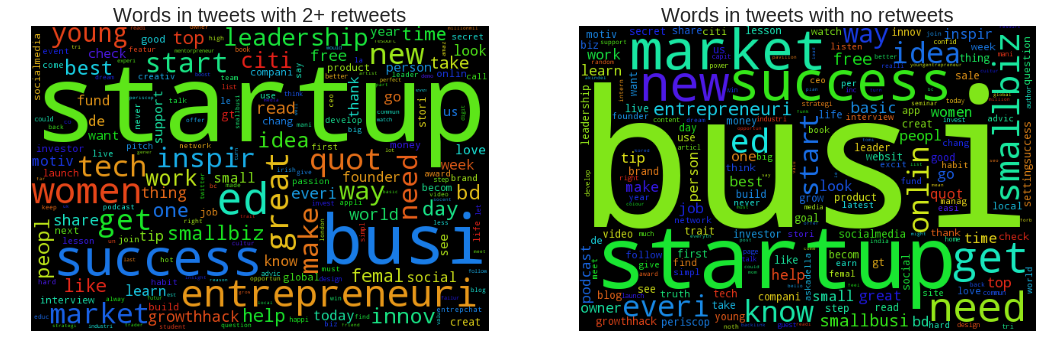

In [9]:
corpusHigh=' '.join(df[df['RetweetCateg']=='high']['textClean'].tolist())
corpusNo=' '.join(df[df['RetweetCateg']=='no']['textClean'].tolist())
wordcloudH = WordCloud(background_color='black',height=400,width=600,
                       stopwords=('entrepreneurship'),relative_scaling=0.8).generate(corpusHigh)
wordcloudL = WordCloud(background_color='black',height=400,width=600,
                       stopwords=('entrepreneurship'),relative_scaling=0.8).generate(corpusNo)
f, axes = plt.subplots(1, 2, figsize=(18, 10), sharex=False)
axes[0].axis("off"),axes[1].axis("off")  
axes[0].set_title("Words in tweets with 2+ retweets",size=20)
axes[0].imshow(wordcloudH),axes[1].imshow(wordcloudL)
axes[1].set_title("Words in tweets with no retweets",size=20)

## Get terms frequencies

In [10]:
highRetw=termFreq(df[df['RetweetCateg']=='high']['textClean'],30)
highRetw.columns=['High']
noRetw=termFreq(df[df['RetweetCateg']=='no']['textClean'],50)
noRetw.columns=['No']
totalretw=highRetw.merge(noRetw, left_index=True, right_index=True)
totalretw.High=totalretw.High/1521
totalretw.No=totalretw.No/31314
totalretw.sort_values('High',ascending=False).head(10)

,High,No
entrepreneur,0.786325,0.837549
startup,0.202498,0.160312
entrepreneurship,0.142669,0.111931
busi,0.109796,0.211088
success,0.071006,0.086639
ed,0.059829,0.047838
entrepreneuri,0.051282,0.033499
women,0.049967,0.023759
great,0.042078,0.026570
quot,0.038133,0.018873


## Plot terms frequencies

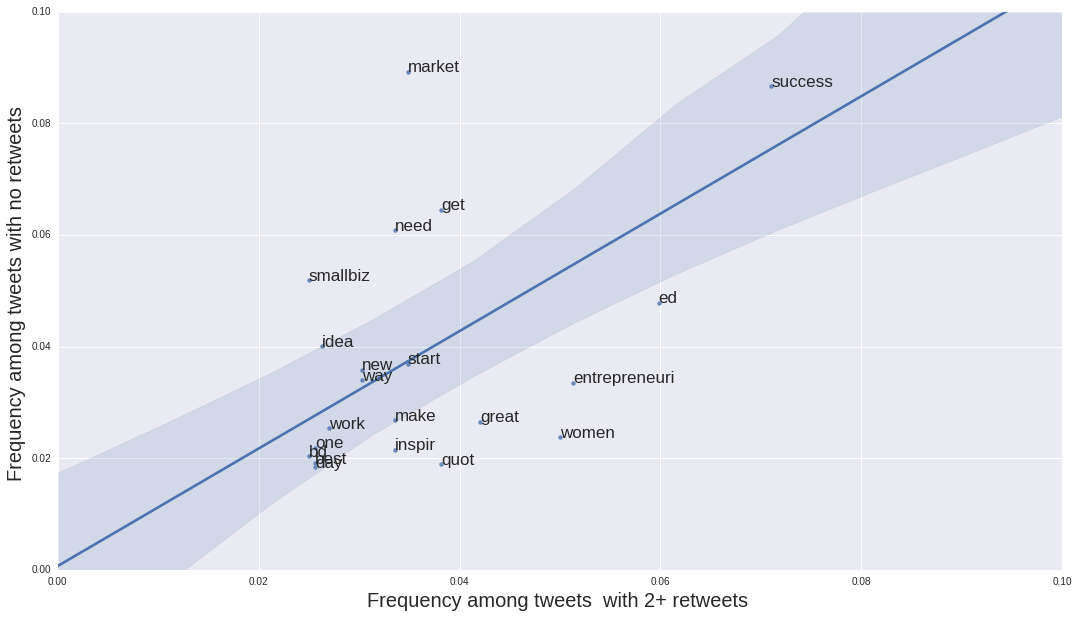

In [16]:
fig, ax = plt.subplots(figsize=(18,10))
sns.regplot(x="High", y="No", data=totalretw,ax=ax)
ax.set_xlim([0.0, 0.1]),ax.set_ylim([0.0, 0.1]) 
ax.set_xlabel('Frequency among tweets  with 2+ retweets ',size=20)
ax.set_ylabel('Frequency among tweets with no retweets ',size=20)
for i, point in totalretw.iterrows():
    if str(point.name) in ['entrepreneur','busi','entrepreneurship','startup']: continue #clean up a bit to make it look better 
    ax.text(point['High'], point['No'], str(point.name),size=17)

## Create Bigrams

In [18]:
vectorizer=CountVectorizer(max_features=25, ngram_range=(2,2))
matrix=vectorizer.fit_transform(df.textClean).todense()
matrixSum=np.sum(matrix, axis=0)
bigrams= pd.DataFrame(matrixSum.transpose(),index = vectorizer.get_feature_names(), columns=['Frequency']) 
bigrams.sort_values('Frequency',ascending=False).head(10)

,Frequency
busi entrepreneur,1540
startup entrepreneur,1436
entrepreneur need,1164
everi entrepreneur,1103
entrepreneur startup,1047
need know,925
onlin market,882
basic everi,868
market basic,851
success entrepreneur,779
